In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import shap

## The Importance of Structure In Machine Learning

It is tempting to think that machine learning algorithms do whatever they need to maximise a given reward function. Indeed, this sentiment is generally echoed in the literature - it is not a causal approach, but it can leverage all available correlations / associations.

Unfortunately, things are not quite *that* simple. 

As we aim to demonstrate below, the structure of the Data-Generating-Process (DGP) interacts strongly with the regressor we use, even if the regressor is something highly adaptive and flexible (like a random forest).

The consequences of this reality are:
- we cannot reliably identify the presence of associations between predictors an outcome
- when using explainability techniques (like decision tree importances, or Shapley values), we can only understand something about what the *model* is doing, and yet this is *strongly* yet *arbitrarily* determined by what is happening in the real-world.


### 1. Start by generating data according to some causal structure

In [2]:
N = 10000

###############################################################
######## EITHER RUN: ########
low_corr = 0
C = np.random.randn(N,1)   # exogenous cause of X
A = 0.8 * np.random.randn(N,1)  # backdoor adjustment variable (also cause of X)
K = A + 0.1 * np.random.randn(N,1)  # backdoor adjustment variable (cause of A and Y)
X = C - 2*A + 0.2 * np.random.randn(N,1)  # treatment variable
F = 3*X + 0.8 * np.random.randn(N,1)  # descendent of treatment variable
D = -2*X + 0.5 * np.random.randn(N,1)  # mediator between x and y
G = D + 0.5 * np.random.randn(N,1)  # descendent of mediator
Y = 2*K - D + 0.2 * np.random.randn(N,1)  # outcome variable 
H = 0.5*Y + 0.1 * np.random.randn(N,1)  # effect of Y

######## OR RUN: ########
# #Alternatively, with lower levels of association
# low_corr = 1 
# C = np.random.randn(N,1)   # exogenous cause of X
# A = 0.8 * np.random.randn(N,1)  # backdoor adjustment variable (also cause of X)
# K = 0.2*A + 0.1 * np.random.randn(N,1)  # backdoor adjustment variable (cause of A and Y)
# X = 0.2*C - 0.4*A + 0.2 * np.random.randn(N,1)  # treatment variable
# F = 0.6*X + 0.8 * np.random.randn(N,1)  # descendent of treatment variable
# D = -0.4*X + 0.5 * np.random.randn(N,1)  # mediator between x and y
# G = 0.2*D + 0.5 * np.random.randn(N,1)  # descendent of mediator
# Y = 0.4*K - D + 0.2 * np.random.randn(N,1)  # outcome variable 
# H = 0.1*Y + 0.1 * np.random.randn(N,1)  # effect of Y
# ###############################################################



feature_names = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H']


### 2. Create functions that provide plots of RF importances for a given set of preds and outcome

In [3]:
def get_importances(predictors, outcome, feature_names, standardize=False):
    '''Gets bi-covs, bi-corrs,linear reg coeffs, RF importances, RF shap and MLP/NN shap output.
    :param predictors: array of preds (N, D)
    :param outcome: array of outcome (N, 1)
    :param feature_names: list of var names as strings
    :param standardize: where to standardize the data (does not apply to the computation of
    biv_covs, biv_corrs, or lr_coefs).
    :return as np.arrays (D,) of biv_corrs, biv_covs, rf_imps, rf_shaps, nn_shap, lin_coefs'''
    
    biv_covs = []
    biv_corrs = []
    for i in range(predictors.shape[1]):
        biv_covs.append(np.abs(np.cov(predictors[:, i], outcome,))[0,1])
        biv_corrs.append(np.abs(np.corrcoef(predictors[:, i], outcome,))[0,1])
        
    print('------------LR (always unstandardizd)---------------')
    # compare with linear regression coefficients
    reg = LinearRegression().fit(predictors, outcome)
    X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.4, random_state=42)
    predictions = reg.predict(X_test)
    lr_coefs =  np.abs(reg.coef_)
    print('MSE', mean_squared_error(predictions, y_test))
    
        
    if standardize:
        predictors = ((predictors - predictors.mean(0)) / (predictors.std(0)))
        X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.4, random_state=42)

    
    print('------------RF---------------')
    forest = RandomForestRegressor(random_state=0)
    forest.fit(X_train, y_train)
    predictions = forest.predict(X_test)
    rf_importances = forest.feature_importances_

    
    shap_sample_inds_train = np.random.choice(np.arange(0,len(X_train)), 500)
    shap_sample_inds_test = np.random.choice(np.arange(0,len(X_test)), 500)
    explainer = shap.TreeExplainer(forest, X_train[shap_sample_inds_train])
    rf_shap_vals = np.mean(np.abs(explainer.shap_values(X_test[shap_sample_inds_test], approximate=True)),0)
    print('MSE', mean_squared_error(predictions, y_test))
    
    print('------------NN---------------')
    nn_regr = MLPRegressor(hidden_layer_sizes=(100,),
                           activation='relu', solver='adam', alpha=0.0001,
                           batch_size='auto', learning_rate='adaptive',
                           learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,)
    nn_regr.fit(X_train, y_train)
    predictions = nn_regr.predict(X_test)
    
    explainer = shap.KernelExplainer(nn_regr.predict, shap.sample(X_train, 500))
    nn_shap_vals = np.mean(np.abs(explainer.shap_values(X_test, nsamples=500)),0)
    print('MSE', mean_squared_error(predictions, y_test))
    
    

    return np.asarray(biv_covs), np.asarray(biv_corrs), rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs


def plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coef, feature_names, graph_name):
    '''Bar plot with variables and different importance measures.'''
    
    all_results = pd.DataFrame([lr_coef, rf_importances, rf_shap_vals, nn_shap_vals]).T
    all_results.index = feature_names
    cols = ['LR-coefs', 'RF-imps', 'RF-Shap', 'NN-Shap']
    all_results.columns = cols
#     min_, max_ = all_results.min(), all_results.max()
#     m = (1 - min_) / (max_ - min_)
#     b = min_ - m*min_
#     all_results = all_results *m + b
    all_results.clip(lower=0, upper=1, inplace=True)
    all_results['bi-corrs'] = biv_corrs
    all_results['Var Names'] = all_results.index

    ax = plt.figure(figsize=(10, 6)).add_subplot(111)
    all_results.plot(ax=ax, x="Var Names", y=cols.append('bi-corrs'), kind="bar",fontsize=16, alpha=0.7)
    bars = ax.patches
    hatches = ''.join(h*len(all_results) for h in 'x/O.')
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=5,fontsize=12)
    ax.set_ylim(0, 1.15)
    ax.figure.savefig(graph_name, dpi=200)



### 3. Invesigate X->Y. Start by looking at the result with ALL variables included

Let's say we are interested to know how important 'X' is for predicting 'Y'.

Look at the result...

Actually, according to our structure defined above, 'H' is an effect of Y. Somehow, none of the other variables are deemed important, even though they are all highly correlated with Y!

Already... things are pretty weird. From these results, it seems 'X' is not associated at all.

In [4]:
predictors = np.concatenate((C, A, K, X, F, D, G, H),1)
outcome =  Y[:,0]

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='all_preds.png')

biv_covs_a,biv_corrs_a, rf_importances_a, rf_shap_vals_a, nn_shap_vals_a, lr_coefs_a = get_importances(predictors, outcome, feature_names, standardize=True)

for i, corr in enumerate(biv_corrs_a):
    print(feature_names[i], corr)

------------LR (always unstandardizd)---------------
MSE 0.019606901302773656
------------RF---------------
MSE 0.03654445053220549
------------NN---------------


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4000 [00:00<?, ?it/s]

MSE 0.02206082402137104
C 0.7519281712558021
A 0.620136526040994
K 0.604530064945566
X 0.9236899864426098
F 0.9159174392338666
D 0.940074815565817
G 0.9327611803402714
H 0.9972104972575833


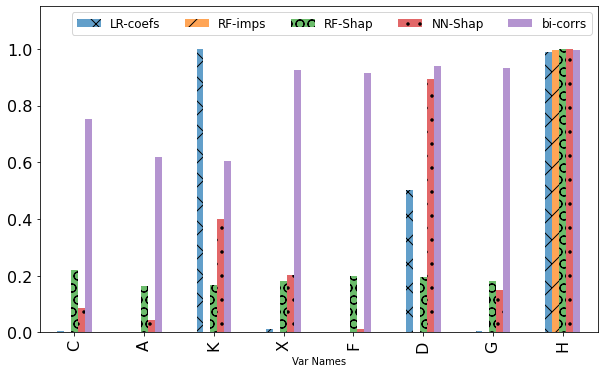

In [5]:

gn = 'all_preds_std.png' if not low_corr else 'all_preds_std_low_corr.png'
plot_results(biv_corrs_a, rf_importances_a, rf_shap_vals_a, nn_shap_vals_a, lr_coefs_a, feature_names, graph_name=gn)

### 4. Let's remove the effect of Y, which is 'H'

Removing 'H', now 'D' is deemed to be very important.

Note that 'D' is a mediator between our treatment 'X' and our outcome 'Y'.

If we know anything about d-separation and Structural Causal Models (SCMS), we might already understand why 'X' is stil not showing up as important - our mediator 'D' is blocking the path!

------------LR (always unstandardizd)---------------
MSE 0.038687275969760085
------------RF---------------
MSE 0.0645942700491884
------------NN---------------


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4000 [00:00<?, ?it/s]

MSE 0.040301695892024064


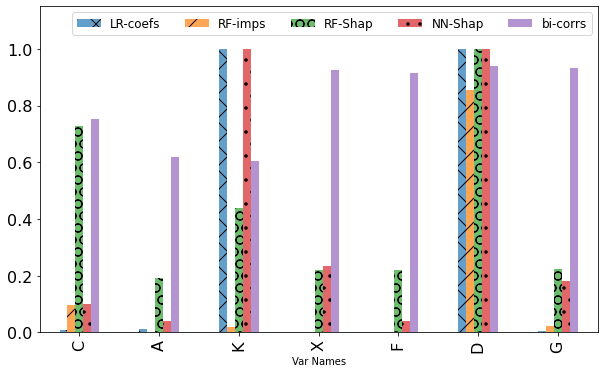

In [6]:
# remove effect of y
predictors = np.concatenate((C, A, K, X, F, D, G),1)
outcome =  Y[:,0]
feature_names_b = ['C', 'A', 'K', 'X', 'F', 'D', 'G']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H.png')
gn = 'no_H_std.png' if not low_corr else 'no_H_std_low_corr.png'
biv_covs_b,biv_corrs_b, rf_importances_b, rf_shap_vals_b, nn_shap_vals_b, lr_coefs_b = get_importances(predictors, outcome, feature_names_b, standardize=True)
plot_results(biv_corrs_b, rf_importances_b, rf_shap_vals_b, nn_shap_vals_b, lr_coefs_b, feature_names_b, graph_name=gn)

### 5. Now let's remove the mediator 'D'. Surely *now* we will see 'X' linked with 'Y'?

Still not! The results now show that 'G' is the most important! But 'G' is an effect (i.e. a descendent) of mediator 'D'. Again, if we know the rules of d-separation, we know that adjusting/conditioning for descendents of mediators also blocks the path.

This shows just how much our model is interacting with the structure of the data!

------------LR (always unstandardizd)---------------
MSE 0.1622130454826388
------------RF---------------
MSE 0.21727297198600773
------------NN---------------


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4000 [00:00<?, ?it/s]

MSE 0.1649425337866838


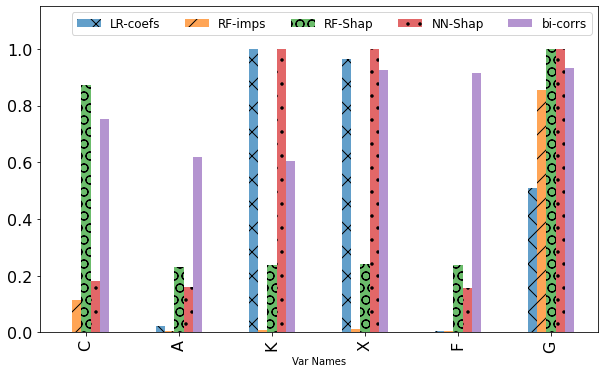

In [7]:
# remove mediator
predictors = np.concatenate((C, A, K, X, F, G),1)
outcome =  Y[:,0]
feature_names_c = ['C', 'A', 'K', 'X', 'F', 'G']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H_no_D.png')

biv_covs_c,biv_corrs_c, rf_importances_c, rf_shap_vals_c, nn_shap_vals_c, lr_coefs_c = get_importances(predictors, outcome, feature_names_c, standardize=True)
gn = 'no_H_no_D_std.png' if not low_corr else 'no_H_no_D_std_low_corr.png'
plot_results(biv_corrs_c, rf_importances_c, rf_shap_vals_c, nn_shap_vals_c, lr_coefs_c, feature_names_c, graph_name=gn)

### 6. Let's remove the descendent of the mediator, surely now we see X linked to Y?

Indeed, finally, there is a strong association identified between 'X' and 'Y'. This is because finally we have not blocked *any* paths between 'X' and 'Y', and so all information can flow between them. Note that this includes spurious (non-causal) paths as well. And indeed, given our structure defined at the start, there is a backdoor path through 'A' and 'K' to 'Y'.

------------LR (always unstandardizd)---------------
MSE 0.2874906837801143
------------RF---------------
MSE 0.342648514644365
------------NN---------------


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4000 [00:00<?, ?it/s]

MSE 0.2906082481793381


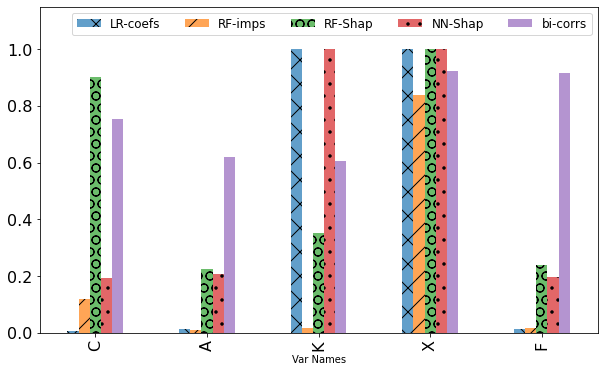

In [8]:
# remove desc of mediator
predictors = np.concatenate((C, A, K, X, F),1)
outcome =  Y[:,0]
feature_names_d = ['C', 'A', 'K', 'X', 'F']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H_no_D_no_G.png')

biv_covs_d ,biv_corrs_d, rf_importances_d, rf_shap_vals_d, nn_shap_vals_d, lr_coefs_d = get_importances(predictors, outcome, feature_names_d, standardize=True)
gn = 'no_H_no_D_no_G_std.png' if not low_corr else 'no_H_no_D_no_G_std_low_corr.png'
plot_results(biv_corrs_d, rf_importances_d, rf_shap_vals_d, nn_shap_vals_d, lr_coefs_d, feature_names_d, graph_name=gn)

### 7. Conclusion? ML models interact strongly with the structure in the data, just like a linear regression model does! 

Importances/Shapley values really tell us nothing reliable about the presence of associations in the data. Depending on which variables we included in the model (and the associated structure) we may get completely the wrong idea: variables which might even be *more strongly* associated than one which has high RF importance, may be represented as not being important at all...

------------LR (always unstandardizd)---------------
MSE 0.04150610712556146
------------RF---------------
MSE 0.9936617790975747
------------NN---------------


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4000 [00:00<?, ?it/s]

MSE 0.04548843733056007


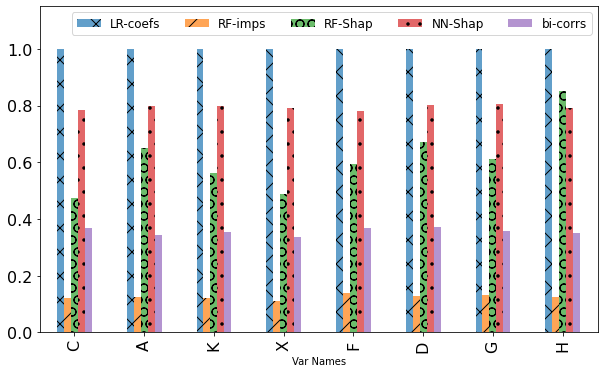

In [9]:
# Check results with naive/trivial structure, where all vars are independent with exogenous noise.

N = 10000
C = np.random.randn(N,1)   
A = np.random.randn(N,1)  
K = np.random.randn(N,1) 
X = np.random.randn(N,1)  
F =  np.random.randn(N,1)  
D =  np.random.randn(N,1)  #
G =  np.random.randn(N,1)  
H =  np.random.randn(N,1) 
Y = C + A + K + X + F + D + G + H + 0.2 * np.random.randn(N,1) 
 
feature_names_e = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H']

predictors = np.concatenate((C, A, K, X, F, D, G, H),1)
outcome =  Y[:,0]

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='all_preds_exog.png')

biv_covs_e,biv_corrs_e, rf_importances_e, rf_shap_vals_e, nn_shap_vals_e, lr_coefs_e = get_importances(predictors, outcome, feature_names_e, standardize=True)
gn = 'all_preds_std_exog.png' 
plot_results(biv_corrs_e, rf_importances_e, rf_shap_vals_e, nn_shap_vals_e, lr_coefs_e, feature_names_e, graph_name=gn)

------------LR (always unstandardizd)---------------
MSE 0.03899848360102655
------------RF---------------
MSE 0.046437969467461856
------------NN---------------


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4000 [00:00<?, ?it/s]

MSE 0.03984471356522982
------------LR (always unstandardizd)---------------
MSE 1.0289763975496304
------------RF---------------
MSE 1.2079647007521452
------------NN---------------


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4000 [00:00<?, ?it/s]

MSE 1.0343910750910257


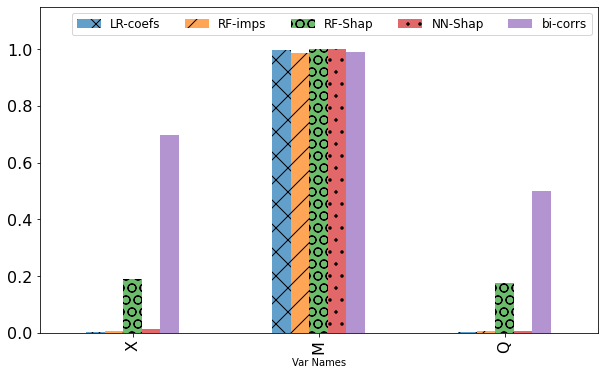

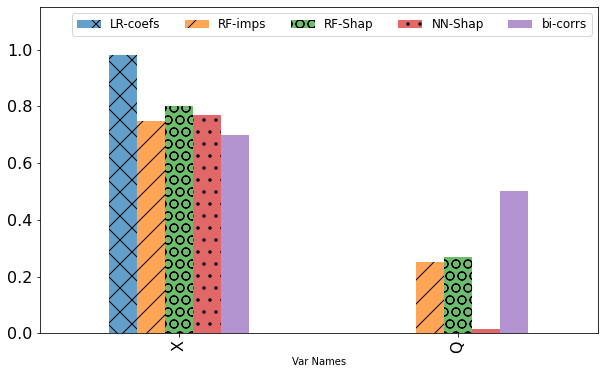

In [10]:
# Check results with simple mediation structure

N = 10000
X = np.random.randn(N,1)   
Q = X + np.random.randn(N,1)   
M = X + np.random.randn(N,1)  
Y = M + 0.2 * np.random.randn(N,1) 
 
feature_names_f = ['X', 'M', 'Q']

predictors = np.concatenate((X, M, Q),1)
outcome =  Y[:,0]

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='all_preds_exog.png')

biv_covs_e,biv_corrs_f, rf_importances_f, rf_shap_vals_f, nn_shap_vals_f, lr_coefs_f = get_importances(predictors, outcome, feature_names_f, standardize=True)
gn = 'mediation_all.png' 
plot_results(biv_corrs_f, rf_importances_f, rf_shap_vals_f, nn_shap_vals_f, lr_coefs_f, feature_names_f, graph_name=gn)


feature_names_g = ['X','Q']
predictors = np.concatenate((X, Q),1)
outcome =  Y[:,0]

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='all_preds_exog.png')

biv_covs_g,biv_corrs_g, rf_importances_g, rf_shap_vals_g, nn_shap_vals_g, lr_coefs_g = get_importances(predictors, outcome, feature_names_g, standardize=True)
gn = 'mediation_only_treatment.png' 
plot_results(biv_corrs_g, rf_importances_g, rf_shap_vals_g, nn_shap_vals_g, lr_coefs_g, feature_names_g, graph_name=gn)


In [11]:
cols = ['bi-corrs', 'RF-imps', 'RF-Shap', 'NN-Shap', 'LR-coefs']

results_a = pd.DataFrame(np.concatenate([biv_corrs_a.reshape(-1,1), rf_importances_a.reshape(-1,1), rf_shap_vals_a.reshape(-1,1), nn_shap_vals_a.reshape(-1,1), lr_coefs_a.reshape(-1,1)],1))
results_a.index = feature_names
results_a.columns = cols
fn = 'results_a.csv' if not low_corr else 'results_a_low_corr.csv'
results_a.to_csv(fn, index=True)

results_b = pd.DataFrame(np.concatenate([biv_corrs_b.reshape(-1,1), rf_importances_b.reshape(-1,1), rf_shap_vals_b.reshape(-1,1), nn_shap_vals_b.reshape(-1,1), lr_coefs_b.reshape(-1,1)],1))
results_b.index = feature_names_b
results_b.columns = cols
fn = 'results_b.csv' if not low_corr else 'results_b_low_corr.csv'
results_b.to_csv(fn, index=True)

results_c = pd.DataFrame(np.concatenate([biv_corrs_c.reshape(-1,1), rf_importances_c.reshape(-1,1), rf_shap_vals_c.reshape(-1,1), nn_shap_vals_c.reshape(-1,1), lr_coefs_c.reshape(-1,1)],1))
results_c.index = feature_names_c
results_c.columns = cols
fn = 'results_c.csv' if not low_corr else 'results_c_low_corr.csv'
results_c.to_csv(fn, index=True)

results_d = pd.DataFrame(np.concatenate([biv_corrs_d.reshape(-1,1), rf_importances_d.reshape(-1,1), rf_shap_vals_d.reshape(-1,1), nn_shap_vals_d.reshape(-1,1), lr_coefs_d.reshape(-1,1)],1))
results_d.index = feature_names_d
results_d.columns = cols
fn ='results_d.csv' if not low_corr else 'results_d_low_corr.csv'
results_d.to_csv(fn, index=True)

results_e = pd.DataFrame(np.concatenate([biv_corrs_e.reshape(-1,1), rf_importances_e.reshape(-1,1), rf_shap_vals_e.reshape(-1,1), nn_shap_vals_e.reshape(-1,1), lr_coefs_e.reshape(-1,1)],1))
results_e.index = feature_names_e
results_e.columns = cols
fn ='results_e.csv' 
results_e.to_csv(fn, index=True)

results_f = pd.DataFrame(np.concatenate([biv_corrs_f.reshape(-1,1), rf_importances_f.reshape(-1,1), rf_shap_vals_f.reshape(-1,1), nn_shap_vals_f.reshape(-1,1), lr_coefs_f.reshape(-1,1)],1))
results_f.index = feature_names_f
results_f.columns = cols
fn = 'results_f.csv'
results_f.to_csv(fn, index=True)

results_g = pd.DataFrame(np.concatenate([biv_corrs_g.reshape(-1,1), rf_importances_g.reshape(-1,1), rf_shap_vals_g.reshape(-1,1), nn_shap_vals_g.reshape(-1,1), lr_coefs_g.reshape(-1,1)],1))
results_g.index = feature_names_g
results_g.columns = cols
fn = 'results_g.csv'
results_g.to_csv(fn, index=True)